# 2D Regression with a DNN Splitting the Database

We'll implement a script to regress 2D data using a two-layer dense neural network trained splitting the database between training set, validation set, and test set.

## Load Data

We load the data using the function `load_data()` contained in `loader.py`.

In [1]:
from loader import load_data

(x, y_gt) = load_data(filename="data_reg_2d_nonlinear.csv")

print("x:", x)
print("y_gt:", y_gt)

x: [[-0.2224211  -0.15564462]
 [ 0.65675937  0.53032608]
 [ 0.21597372  0.57542981]
 [ 0.0472221  -0.08081086]
 [ 0.02184948 -0.05671952]
 [ 0.39099227 -0.37932797]
 [-1.27367568 -0.34172716]
 [ 0.37215329 -0.74583882]
 [-0.01044955  1.19439785]
 [-1.29713475  1.24549235]
 [-1.02855559 -1.48320358]
 [ 0.45099998 -0.75056005]
 [ 0.03685162 -0.66335451]
 [ 1.55966194 -2.45834961]
 [-0.07402267 -1.13765725]
 [ 2.05966154  2.10391695]
 [ 0.16893866  1.06634604]
 [-0.24129401 -0.42943993]
 [-1.00245756  0.04010673]
 [-0.5273956  -0.91670649]
 [-0.49435188  1.34816325]
 [ 1.85039308  0.52347435]
 [-0.10394141 -1.35018048]
 [-0.88089055  1.42690126]
 [ 0.08176963 -2.15782374]
 [-1.05339772 -0.05170006]
 [ 0.15367086 -1.92569791]
 [-1.22395047 -0.42954738]
 [ 0.03710187 -1.36820513]
 [ 1.0630793   0.02247431]
 [-1.03096003  0.39161347]
 [ 0.07131787 -0.5749716 ]
 [ 0.46953539 -1.38237299]
 [-0.11606302 -0.34084266]
 [ 1.50326854  0.34406896]
 [-0.5641367  -0.29503353]
 [ 0.75829488 -0.79417023

## Splitting Datasets



In [2]:
from numpy import split, delete
from numpy.random import choice

num_samples = len(x)
split = .70

num_samples_train = int(split * num_samples)
train_idx = choice(num_samples, num_samples_train, replace=False)

x_train = x[train_idx] # train inputs
y_gt_train = y_gt[train_idx] # train groundtruths

x_val = delete(x, train_idx, axis=0) # validation inputs
y_gt_val = delete(y_gt, train_idx, axis=0) # validation groundtruths

## Two-Layer Neural Network

We now create a two-layer neural network and randomly initialize it.

In [3]:
from numpy.random import default_rng

rng = default_rng()

def sigmoid(x):
    from numpy import exp
    return 1 / (1 + exp(-x))

num_neurons = 10

wa = rng.standard_normal(size=(2, num_neurons)) # input weights layer 1
wb = rng.standard_normal(size=(num_neurons, 1)) # input weights layer 2 (output)

y_p_train = sigmoid(x_train @ wa) @ wb
y_p_val = sigmoid(x_val @ wa) @ wb

We now plot the data and predictions using the functions `plot_pred_2d` and `plot_pred_vs_gt()` from `plotting.py`.

For the training set:

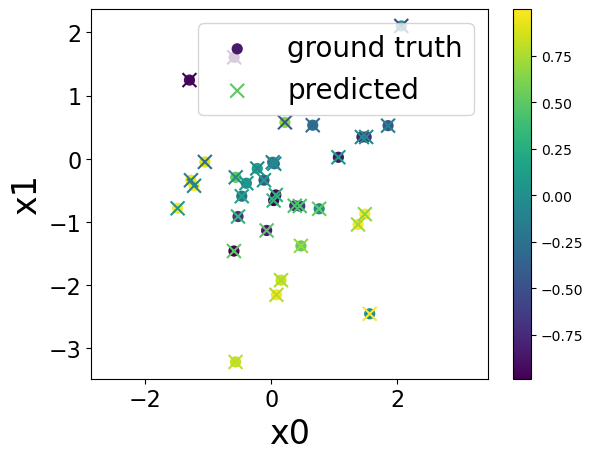

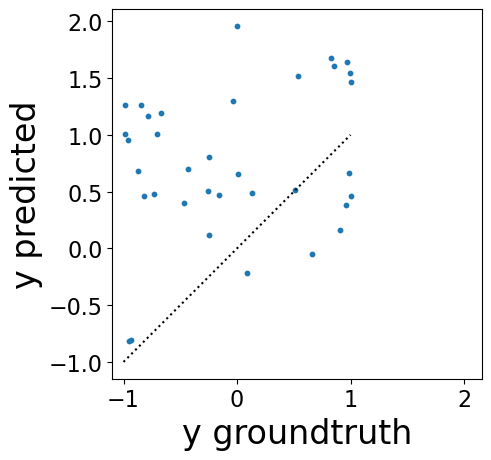

In [4]:
from plotting import plot_pred_2d, plot_pred_vs_gt

plot_pred_2d(x_train, y_gt_train, y_p_train)
plot_pred_vs_gt(y_gt_train, y_p_train)

... and for the validation set.

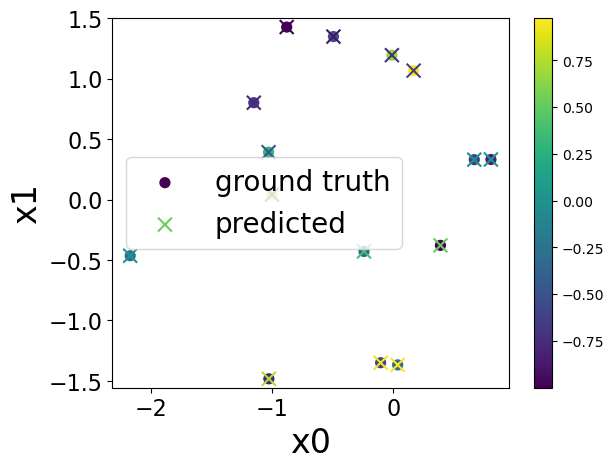

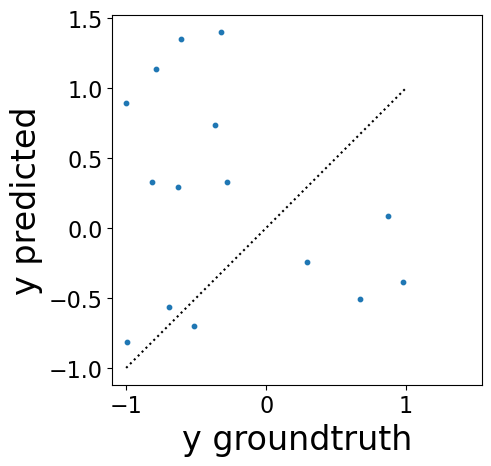

In [5]:
plot_pred_2d(x_val, y_gt_val, y_p_val)
plot_pred_vs_gt(y_gt_val, y_p_val)

## Training

We now train the neural network...

In [6]:
from numpy import reshape, transpose, sum, zeros, mean
from numpy.random import permutation

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))
	
num_samples = len(x_train)
num_batches = 7
batch_size = int(num_samples / num_batches)
num_epochs = 10**4
eta = .1 # learning rate

mse_train = zeros((num_epochs,))
mse_val = zeros((num_epochs,))

for epoch in range(num_epochs):
	permuted_order_samples = permutation(num_samples)
	x_permuted = x_train[permuted_order_samples]
	y_gt_permuted = y_gt_train[permuted_order_samples]
	
	for batch_start in range(0, num_samples, batch_size):

		dwa = zeros(wa.shape) # initialize weight increments layer 1
		dwb = zeros(wb.shape) # initialize weight increments layer 2

		for selected in range(batch_start, batch_start + batch_size):
			x_selected = reshape(x_permuted[selected], (1, -1))
			y_gt_selected = reshape(y_gt_permuted[selected], (1, -1))

			x_selected_a = x_selected # input layer 1
			p_a = x_selected_a @ wa # activation potential layer 1
			y_selected_a = sigmoid(p_a) # output layer 1
			
			x_selected_b = y_selected_a # input layer 2 (output neuron)
			p_b = x_selected_b @ wb # activation potential layer 2
			y_selected_b = p_b # output neuron layer 2

			y_p_selected = y_selected_b
			
			error = y_p_selected - y_gt_selected

			delta_b = error * 1
			wb -= eta * delta_b * transpose(x_selected_b) # update weights layer 2

			delta_a = sum(wb * delta_b, axis=1) * d_sigmoid(p_a)
			wa -= eta * delta_a * transpose(x_selected_a) # update weights layer 1

		wa += dwa / batch_size # update weights layer 1
		wb += dwb / batch_size # update weights layer 2

	y_p_train = sigmoid(x_train @ wa) @ wb
	mse_train[epoch] = mean((y_p_train - y_gt_train)**2)

	y_p_val = sigmoid(x_val @ wa) @ wb
	mse_val[epoch] = mean((y_p_val - y_gt_val)**2)

	print(f"ep={epoch} MSEtrain={mse_train[epoch]:.4f} MSEval={mse_val[epoch]:.4f}")

ep=0 MSEtrain=0.5796 MSEval=0.6879
ep=1 MSEtrain=0.5632 MSEval=0.7988
ep=2 MSEtrain=0.4651 MSEval=0.5231
ep=3 MSEtrain=0.4782 MSEval=0.6583
ep=4 MSEtrain=0.4310 MSEval=0.5605
ep=5 MSEtrain=0.4238 MSEval=0.5525
ep=6 MSEtrain=0.4203 MSEval=0.5747
ep=7 MSEtrain=0.4301 MSEval=0.5947
ep=8 MSEtrain=0.3935 MSEval=0.5016
ep=9 MSEtrain=0.3824 MSEval=0.4865
ep=10 MSEtrain=0.3879 MSEval=0.5213
ep=11 MSEtrain=0.4615 MSEval=0.4674
ep=12 MSEtrain=0.3488 MSEval=0.4536
ep=13 MSEtrain=0.4936 MSEval=0.4186
ep=14 MSEtrain=0.3419 MSEval=0.4005
ep=15 MSEtrain=0.3461 MSEval=0.5074
ep=16 MSEtrain=0.3502 MSEval=0.5412
ep=17 MSEtrain=0.2889 MSEval=0.3908
ep=18 MSEtrain=0.2888 MSEval=0.3093
ep=19 MSEtrain=0.3355 MSEval=0.5078
ep=20 MSEtrain=0.2851 MSEval=0.3378
ep=21 MSEtrain=0.2670 MSEval=0.3891
ep=22 MSEtrain=0.2612 MSEval=0.3131
ep=23 MSEtrain=0.3142 MSEval=0.2755
ep=24 MSEtrain=0.2335 MSEval=0.3471
ep=25 MSEtrain=0.2234 MSEval=0.2971
ep=26 MSEtrain=0.2383 MSEval=0.3791
ep=27 MSEtrain=0.2013 MSEval=0.2490
ep

We can now plot the _mean squared error_ as a function of the training epoch using function `plot_mse()` now added to `plotting` for the training set ...

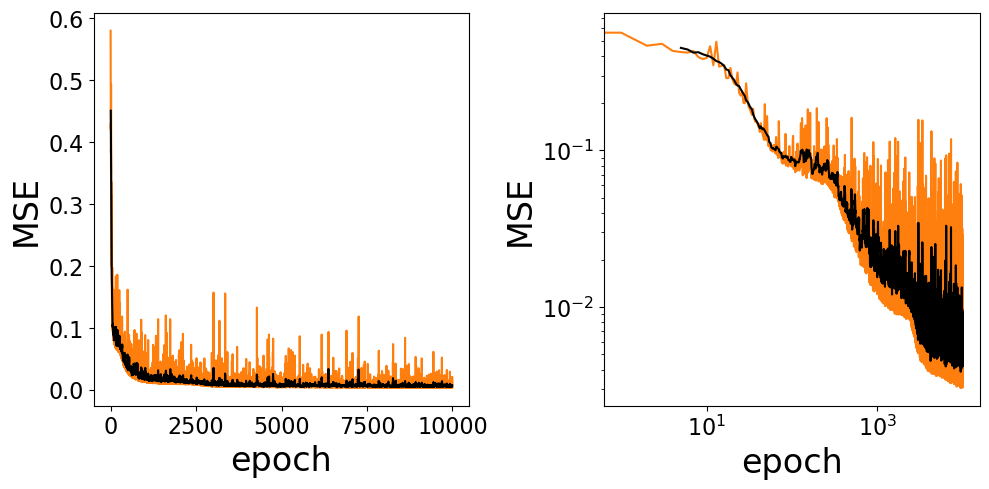

In [7]:
# from plotting import plot_mse

plot_mse(mse_train)

... and for the validation set.

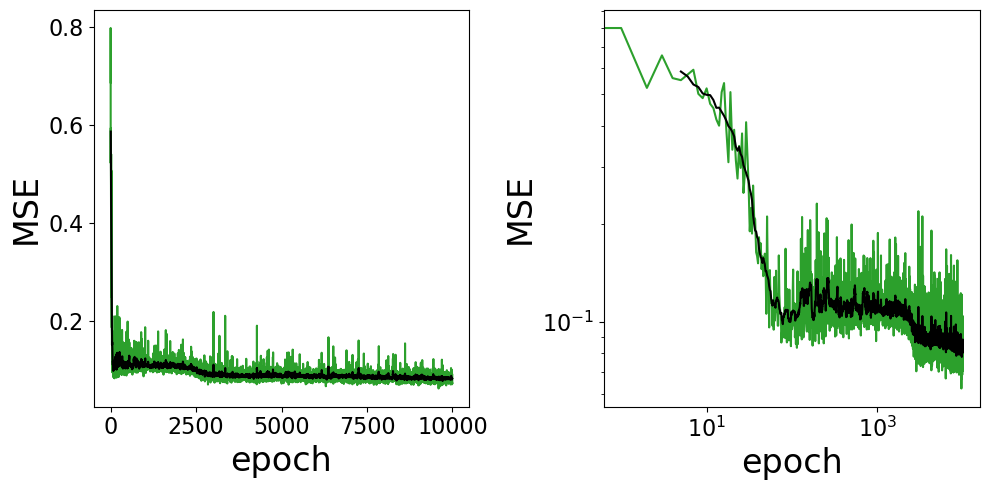

In [8]:
plot_mse(mse_val, color="tab:green")

## Testing

We now check how the trained neuron works on the test data.

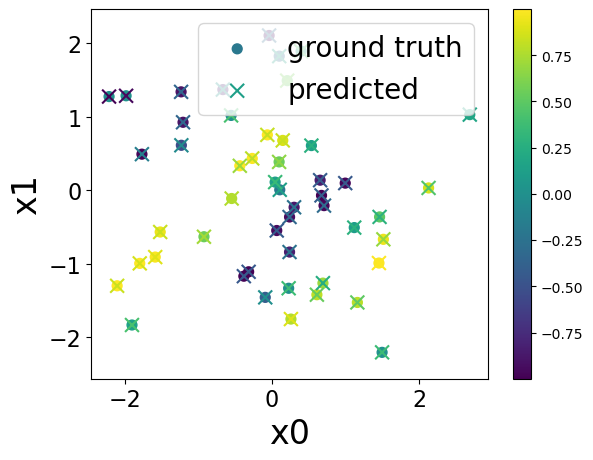

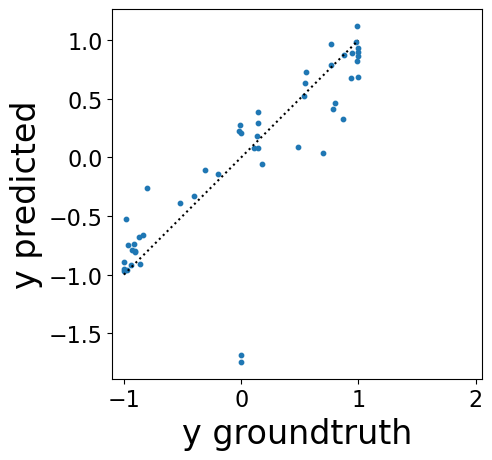

In [9]:
(x_test, y_gt_test) = load_data(filename="data_reg_2d_nonlinear_test.csv")

y_p_trained_test = sigmoid(x_test @ wa) @ wb

plot_pred_2d(x_test, y_gt_test, y_p_trained_test)
plot_pred_vs_gt(y_gt_test, y_p_trained_test)